# TODO
# - rewrite this in xsimlab!

In [1]:
# MISSING DEPENDENCIES:
# - phydra.aux# - phydra.forcing

### ! This still has to be translated into xsimlab !

# EMPOWER Model (NPZD slab model)

In [1]:
import numpy as np
#import xsimlab as xs
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [5]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

#import pandas
import numpy as np
#import scipy.interpolate as intrp

import sys
sys.path.append('../../phydra_OSM/')

from phydra.aux import sliceparams, sliceoffparams, checkreplaceparam
from phydra.forcing import Forcing

from lmfit import minimize, Parameters #, Parameter, report_fit

In [6]:
class Nutrient:
    """"""
    def __init__(self, allpars, slicedpars, num):
        self.num = num
        self.nuttype = checkreplaceparam(allpars, slicedpars, 'nuttype')
        self.type = self.returnnuttype()

    def mixing(self, N0, N, K):
        """"""
        # TODO this only works for Nitrate as of now
        return K * (N0 - N[self.num])

    def returnnuttype(self):
        if self.nuttype == 0:
            return 'Nitrate'
        if self.nuttype == 1:
            return 'Phosphate'
        if self.nuttype == 2:
            return 'Silicate'
        if self.nuttype == 3:
            return 'Iron'

class Phytoplankton:
    """"""
    def __init__(self, allpars, slicedpars, num):
        self.num = num

        self.kw = checkreplaceparam(allpars, slicedpars, 'kw')
        #self.OptI = checkreplaceparam(allpars, slicedpars, 'OptI')

        self.U_N = checkreplaceparam(allpars, slicedpars, 'U_N')
        #self.U_P = checkreplaceparam(allpars, slicedpars, 'U_P')
        #self.U_Si = checkreplaceparam(allpars, slicedpars, 'U_Si')

        #self.v = checkreplaceparam(allpars, slicedpars, 'v')

        #self.muP = checkreplaceparam(allpars, slicedpars, 'muP')
        self.moP = checkreplaceparam(allpars, slicedpars, 'moP')
        self.moP_quad = checkreplaceparam(allpars, slicedpars, 'moP_quad')

        #self.ratioSi = checkreplaceparam(allpars, slicedpars, 'ratioSi')

        self.pfn = allpars['phyto_num'].value
        self.zn = allpars['zoo_num'].value

        self.kc = checkreplaceparam(allpars, slicedpars, 'kc')
        self.alpha = checkreplaceparam(allpars, slicedpars, 'alpha')
        self.VpMax = checkreplaceparam(allpars, slicedpars, 'VpMax')

        self.zoolist = ['Z'+str(j+1) for j in range(self.zn)]
        self.grazepref = [checkreplaceparam(allpars, slicedpars, string) for string in self.zoolist]

    def growth(self):
        return self.muP

    def uptake(self, N):
        """Michealis-Menten uptake of Nutrients"""
        # TODO: add functionality of multiple Nutrients/formulations
        Uptake = N[0] / (N[0] + self.U_N)
        return Uptake

    def lightharvesting(self, MLD, PAR, P, VPT, type='Smith'):
        """Light - modification of phytoplankton growth rate"""
        if type == 'Steele':
            lighthrv = 1. / (self.kw * MLD) * \
                       (-np.exp(1. - PAR / self.OptI) - (
                           -np.exp((1. - (PAR * np.exp(-self.kw * MLD)) / self.OptI))))
            return lighthrv
        # TODO: convert P to chlorophyll!
        if type == 'Smith':
            PAR = PAR
            kPAR = self.kw + self.kc * sum(P)
            x_0 = self.alpha * PAR * np.exp(- kPAR * 0)
            x_H = self.alpha * PAR * np.exp(- kPAR * MLD)
            VpH = (VPT / (kPAR * MLD)) * \
                  np.log(
                      (x_0 + np.sqrt(VPT ** 2 + x_0 ** 2)) /
                      (x_H + np.sqrt(VPT ** 2 + x_H ** 2))
                  )
            return VpH/VPT

    def tempdepgrowth(self, Tmld):
        """"""
        #tdp = np.exp(0.063 * Tmld)
        tdp = self.VpMax * 1.066 ** Tmld
        return tdp

    def mortality(self, P, type='linear'):
        """"""
        if type == 'linear':
            mortal = self.moP * P[self.num]
            return mortal
        elif type == 'quadratic':
            mortal = self.moP_quad * P[self.num] ** 2
            return mortal

    def zoograzing(self, Gj, P, Z, D):
        """"""
        # take the general grazing term from each zooplankton, multiply by phyto fraction and sum
        Grazing = [Gj[j] * (self.grazepref[j] * P[self.num] ** 2) * Z[j] for j in range(self.zn)]
        GrazingPerZ = sum(Grazing)
        return GrazingPerZ

    def sinking(self, MLD, P):
        """"""
        Sink = self.v / MLD * P[self.num]  # Phytoplankton sinking as a function of MLD and sinking rate
        return Sink

class Zooplankton:
    """"""
    def __init__(self, allpars, slicedpars, num):
        self.num = num
        # zooplankton
        self.moZ = checkreplaceparam(allpars, slicedpars, 'moZ')
        self.muZ = checkreplaceparam(allpars, slicedpars, 'muZ')
        # grazing params
        self.Kp = checkreplaceparam(allpars, slicedpars, 'Kp')
        self.deltaZ = checkreplaceparam(allpars, slicedpars, 'deltaZ')

        #self.muIntGraze = checkreplaceparam(allpars, slicedpars, 'muIntGraze')
        #self.kIntGraze = checkreplaceparam(allpars, slicedpars, 'kIntGraze')

        self.pred = checkreplaceparam(allpars, slicedpars, 'pred')
        #self.deltaLambda = checkreplaceparam(allpars, slicedpars, 'deltaLambda')

        self.pfn = allpars['phyto_num'].value
        self.zn = allpars['zoo_num'].value
        self.dn = allpars['det_num'].value

        self.beta = 2  # for Vallina KTW Grazing, beta = 1 : Holling Type II, beta = 2 : Holling Type III
        self.ksat = self.Kp

        self.phylist = ['P'+ str(i + 1) for i in range(self.pfn)] # + str(i + 1)
        self.detlist = ['D'+ str(i + 1) for i in range(self.dn)] # + str(i + 1)
        self.zoointlistfeed = ['Zint_feed' + str(j + 1) for j in range(self.zn)]  # list of feeding
        self.zoointlistgrazed = ['Zint_grazed' + str(j + 1) for j in range(self.zn)]
        # print(self.phylist, self.zoointlistfeed, self.zoointlistgrazed)

        self.feedpref = [checkreplaceparam(allpars, slicedpars, string) for string in self.phylist]
        self.detfeedpref = [checkreplaceparam(allpars, slicedpars, string) for string in self.detlist]
        print('D feedpref',self.detfeedpref,'P feedpref',self.feedpref)
#        self.interfeedpref = [checkreplaceparam(allpars, slicedpars, string) for string in self.zoointlistfeed]
#        self.intergrazedpref = [checkreplaceparam(allpars, slicedpars, string) for string in self.zoointlistgrazed]

        self.beta_feed = checkreplaceparam(allpars, slicedpars, 'beta_feed')
        self.kN_feed = checkreplaceparam(allpars, slicedpars, 'kN_feed')

    def zoofeeding(self, P, Z, D, func='anderson'):
        if func == 'anderson':
            FrhoP = sum([self.feedpref[i] * P[i] ** 2 for i in range(self.pfn)])
            #FrhoZ = sum([self.interfeedpref[j] * Z[j] ** 2 for j in range(self.zn)])
            Frho = FrhoP #+ FrhoZ
            GrazingProb = self.muZ / (self.ksat ** 2 + Frho)
            return GrazingProb

        elif func == 'fasham': #put the holling type num here
            FrhoP = sum([self.feedpref[i] * P[i] ** 2 for i in range(self.pfn)])
            #FrhoZ = sum([self.interfeedpref[j] * Z[j] ** 2 for j in range(self.zn)])
            Frho = FrhoP #+ FrhoZ  # active switching coefficient
            FpP = sum([self.feedpref[i] * P[i] for i in range(self.pfn)])
            #FpZ = sum([self.interfeedpref[j] * Z[j] for j in range(self.zn)])
            Fp = FpP #+ FpZ  # total food available
            GrazingProb = self.muZ * (1 / (self.ksat * Fp + Frho))
            return GrazingProb

        elif func == 'vallina':
            FrhoP = sum([self.feedpref[i] * P[i] ** 2 for i in range(self.pfn)])
            #FrhoZ = sum([self.interfeedpref[j] * Z[j] ** 2 for j in range(self.zn)])
            Frho = FrhoP #+ FrhoZ  # active switching coefficient
            FpP = sum([self.feedpref[i] * P[i] for i in range(self.pfn)])
            #FpZ = sum([self.interfeedpref[j] * Z[j] for j in range(self.zn)])
            Fp = FpP #+ FpZ  # total food available
            GrazingProb = self.muZ * (1 / Frho) * ((Fp ** self.beta) / (self.ksat ** self.beta + Fp ** self.beta))
            return GrazingProb

        elif func == 'hollingtypeIII':
            FrhoP = sum([self.feedpref[i] * P[i] ** 2 for i in range(self.pfn)])
            FrhoD = sum([self.detfeedpref[j] * D[j] ** 2 for j in range(self.dn)])
            Frho = FrhoP + FrhoD
            #print('Frho',Frho,'FrhoP',FrhoP,P,'FrhoD',FrhoD,D)
            GrazingProb = self.muZ / (self.ksat ** 2 + Frho)
            return GrazingProb

        else:
            print('no grazing formulation given, wrong func key')

    def fullgrazing(self, Gj, P, Z, D):
        # phytouptake + zooplankton per zooplankton for each phyto
        IprobP = [Gj[self.num] * (self.feedpref[i] * P[i] ** 2) for i in range(self.pfn)]  # grazeprob per each PFT
        IprobD = [Gj[self.num] * (self.detfeedpref[j] * D[j] ** 2) for j in range(self.dn)]
        Iprob = IprobP + IprobD
        #perhaps here = multiply by Z before summing Iprobs!
        Itots = sum(Iprob)
        Itot = Itots * Z[self.num]
        #print('Itots', Itots,Z, 'IprobP', IprobP, P, 'IprobD', IprobD, D)
        return Itot

    def assimgrazing(self, ZooFeeding):
        # AssimGrazing = self.deltaZ * ZooFeeding[self.num]
        AssimGrazing = self.beta_feed * self.kN_feed * ZooFeeding[self.num]
        return AssimGrazing

    def unassimilatedgrazing(self, ZooFeeding, pool='N'):
        #UnAsGraze = (1. - self.deltaZ) * ZooFeeding[self.num]
        if pool == 'N':
            UnAsGraze = self.beta_feed * (1-self.kN_feed) * ZooFeeding[self.num]
            return UnAsGraze
        elif pool == 'D':
            UnAsGraze = (1-self.beta_feed) * ZooFeeding[self.num]
            return UnAsGraze

    def mortality(self, Z, type='linear'):
        if type == 'linear':
            total_moZ = self.moZ * Z[self.num]
            return total_moZ
        if type == 'quadratic':
            total_moZ = self.pred * Z[self.num] ** 2
            return total_moZ


class Detritus:
    def __init__(self, allpars, slicedpars, num):
        self.num = num
        self.deltaD = checkreplaceparam(allpars, slicedpars, 'deltaD_N')

        self.zn = allpars['zoo_num'].value
        self.zoolist = ['Z' + str(j + 1) for j in range(self.zn)]
        self.detgrazepref = [checkreplaceparam(allpars, slicedpars, string) for string in self.zoolist]

    def remineralisation(self, D):
        return D[self.num] * self.deltaD

    def zoograzing(self, Gj, D, Z):
        """"""
        # take the general grazing term from each zooplankton, multiply by phyto fraction and sum
        Grazing = [Gj[j] * (self.detgrazepref[j] * D[self.num] ** 2) * Z[j] for j in range(self.zn)]
        GrazingPerZ = sum(Grazing)
        return GrazingPerZ


class StateVariables:
    """"""
    def __init__(self,params, SVtype):
        self.type = SVtype
        self.num = params[SVtype + '_num'].value
        self.allpars = params
        self.svs = self.createlistofsvs()
        print(self.type,self.num,'created')

    def __getattr__(self, key):
        """ This function is necessary for the StateVariables class to
        pass functions to the contained state variables when called within the ODE"""
        def fn(*args,**kwargs):
            return np.array([getattr(x, key)(*args,**kwargs) for x in self.svs])
        return fn

    def sv(self, *args):
        if self.type == 'nuts':
            return Nutrient(*args)
        elif self.type == 'phyto':
            return Phytoplankton(*args)
        elif self.type == 'zoo':
            return Zooplankton(*args)
        elif self.type == 'det':
            return Detritus(*args)

    def createlistofsvs(self):
        return [self.sv(self.allpars, sliceparams(self.allpars, self.type + str(i + 1)), i) for i in range(self.num)]


class Physics:
    """"""
    def __init__(self,params,fxtype, lat, lon, rbb):
        self.parameters = params
        self.type = fxtype
        if self.type == 'slab':
            self.forcing = Forcing('WOA2018', lat, lon, rbb)
        elif self.type == 'EMPOWER':
            self.forcing = Forcing('EMPOWER', None,None,None)

    def K(self, MLD, mix='h+'):
        if mix == 'h+':
            MLDt = MLD[0]
            MLDt_deriv = MLD[1]
            kappa = self.parameters['kappa'].value
            return (kappa + max(MLDt_deriv, 0)) / MLDt
        if mix == 'Z':
            MLDt = MLD[0]
            MLDt_deriv = MLD[1]
            return MLDt_deriv / MLDt

    def omegaMix(self, MLD, type='std'):
        if type == 'std':
            return (self.parameters['wmix'].value + max(MLD[1],0)) / MLD[0]
        elif type == 'D':
            return (self.parameters['wmix'].value + max(MLD[1],0) + self.parameters['vD'].value) / MLD[0]

    def MLD(self,t):
        return np.array([self.forcing.MLD.return_interpvalattime(t), self.forcing.MLD.return_derivattime(t)])

    def N0(self, t):
        return self.forcing.NOX.return_interpvalattime(t)

    def PAR(self, t):
        return self.forcing.PAR.return_interpvalattime(t)

    def Tmld(self, t):
        return self.forcing.SST.return_interpvalattime(t)


class ModelSetup:
    """"""
    def __init__(self, params, lat, lon, rbb):
        self.nutrients = StateVariables(params, 'nuts')
        self.phytoplankton = StateVariables(params, 'phyto')
        self.zooplankton = StateVariables(params, 'zoo')
        self.detritus = StateVariables(params, 'det')
        self._classes = [self.nutrients, self.phytoplankton, self.zooplankton, self.detritus]

        self.physics = Physics(params, 'slab', lat, lon, rbb)  # 'EMPOWER' / 'slab' as fxtype instead

    @property
    def classes(self):
        return self._classes

    def timestep_init(self,x):
        n = self.nutrients.num
        p = self.phytoplankton.num
        z = self.zooplankton.num
        d = self.detritus.num
        nuts = x[0:n]
        phyto = x[n:n+p]
        zoo = x[n+p:n+p+z]
        det = x[n+p+z:n+p+z+d]
        rest = x[n+p+z+d:]
        return nuts, phyto, zoo, det, rest

In [7]:
# MODEL ODE
def empower(x,t, modelsetup, q):
    """System of ODEs"""

    N, P, Z, D, outputlist = modelsetup.timestep_init(x)
    physx = modelsetup.physics
    #print(N,P,Z,D)
    #print(x)
    # N = [Ni]
    # P = [P1]
    # Z = [Z1]
    # D = [D]

    MLD = physx.MLD(t)  # MLD = [int_MLD, deriv_MLD]
    N0 = physx.N0(t)  # N0 = [Ni0,P0,Si0]
    PAR = physx.PAR(t)
    Tmld = physx.Tmld(t)

    Mix = physx.omegaMix(MLD)  # i.e. there is constant mixing & increased mix when MLD shallowing
    #print('Mix',Mix)
    Mix_D = physx.omegaMix(MLD, type='D')  # i.e. there is constant mixing & increased mix when MLD shallowing

    # Grazing
    Gj = z.zoofeeding(P, Z, D, func='hollingtypeIII')  # feeding probability for all food
    ZooFeeding = z.fullgrazing(Gj, P, Z, D)

    PTempDepGrow = p.tempdepgrowth(Tmld)
    PNutUptake = p.uptake(N)
    PLightHarv = p.lightharvesting(MLD[0], PAR, P, sum(PTempDepGrow)) * 24/75  # (C to Chl)
    # Phytoplankton Fluxes
    PGains = PTempDepGrow * PNutUptake * PLightHarv * P

    PLinMort = p.mortality(P, type='linear')
    PQuadMort = p.mortality(P, type='quadratic')
    PMortality = PLinMort + PQuadMort
    PZooGrazed = p.zoograzing(Gj, P, Z, D)
    PMixing = P * Mix
    PLosses = PZooGrazed + PMortality + PMixing

    # Zooplankton Fluxes
    ZGains = z.assimgrazing(ZooFeeding)
    ZLinMort = z.mortality(Z, type='linear')
    ZQuadMort = z.mortality(Z, type='quadratic')
    ZMixing = Z * Mix
    ZLosses = ZLinMort + ZQuadMort + ZMixing

    # Detritus Fluxes
    ZUnassimFeedDetritus = z.unassimilatedgrazing(ZooFeeding, pool='D')
    DGains = sum(ZUnassimFeedDetritus) + sum(ZLinMort) + sum(PMortality)
    DRemin = d.remineralisation(D)
    DZooGrazed = d.zoograzing(Gj, D, Z)
    DMixing = D * Mix_D
    DLosses = DZooGrazed + DRemin + DMixing

    ZUnassimFeedNitrate = z.unassimilatedgrazing(ZooFeeding, pool='N')
    NMixing = Mix * (N0 - N)
    #print(NMixing)
    Px = PGains - PLosses
    Nx = - sum(PGains) + DRemin + sum(ZUnassimFeedNitrate) + NMixing# Nutrient draw down
    Zx = ZGains - ZLosses  # Zooplankton losses due to mortality and mixing
    Dx = DGains - DLosses   # Detritus

    out = [Nx, Px, Zx, Dx]

    return np.concatenate([out], axis=None) #,

In [64]:
######### PARAMETER SETUP #############
parameters = Parameters()

#NEW EMPOWER:
parameters.add('wmix', value=0.13, vary=False) # prev 1
parameters.add('vD', value=6.43, vary=False) # prev 1

# PHYSICS
#parameters.add('kappa', value=0.1, vary=False)  # vary=False) # min=0.09, max=0.11) # Diffusive mixing across thermocline (m*d^-1)
parameters.add('kw', value=0.04, vary=False)     # Light attenuation constant of water (m^-1)
parameters.add('kc', value=0.03, vary=False)      # Light attenuation via phytoplankton pigment (m^-1)


# NUTRIENT(s)
parameters.add('nuts_num', value=1)
parameters.add('nuts1_nuttype', value=0)  # Nitrate

# PHYTOPLANKTON(s)
parameters.add('phyto_num', value=1)
parameters.add('alpha', value=0.034, vary=False) #prev 0.15  # initial slope of the P-I curve 0.034
parameters.add('VpMax', value=2.5, vary=False)    # maximum photosynthetic rate

parameters.add('moP', value=0.015, vary=False) # prev: 0.1   # Phytoplankton mortality (d^-1)
parameters.add('moP_quad', value=0.025, vary=False)    # Phytoplankton mortality (d^-1)

parameters.add('U_N', value=0.85, vary=False) # prev: 1.5   # Nitrate Half Saturation Constant


#parameters.add('OptI', value=40, vary=False)    # Optimum irradiance (einstein*m^-2*d^-1)
#parameters.add('ratioSi', value=0, vary=False)  # Silicate ratio ## FALLBACK PARAM FOR OTHER PFTs
#parameters.add('U_P', value=0, vary=False)    # Phosphate Half Saturation Constant
#parameters.add('U_Si', value=0, vary=False)   # Silicate Half Saturation Constant
#parameters.add('muP', value=1.2, vary=False)    # Phytoplankton maximum growth rate (d^-1)
#parameters.add('v', value=1, vary=False)    # Phytoplankton sinking rate (m d^-1)

# ZOOPLANKTON(s)
parameters.add('zoo_num', value=1)
parameters.add('moZ', value=0.02, vary=False)   #prev 0.01     # Zooplankton mortality (d^-1)
parameters.add('deltaZ', value=0.75, vary=False)    # Zooplankton Grazing assimilation coefficient (-)
parameters.add('beta_feed', value=0.69, vary=False)
parameters.add('kN_feed', value=0.75, vary=False)

parameters.add('Kp', value=0.6, vary=False)     # Zooplankton Grazing saturation constant (-)
parameters.add('pred', value=0.34, vary=False) #prev 0.1 # quadratic higher order predation rate on zooplankton
parameters.add('muZ', value=1.0, vary=False)    # Zooplankton maximum grazing rate (d^-1)

# ZOO Feed Prefs
parameters.add('zoo1_P1', value=.67, vary=False)
parameters.add('zoo1_D1', value=.33, vary=False)

# CONVERT FEEDPREFS TO GRAZEPREF FOR CALCULATION OF GRAZING
#parameters.add('zoo1_Zint_grazed1', value=parameters['zoo1_Zint_feed1'].value, vary=False)

parameters.add('phyto1_Z1', value=parameters['zoo1_P1'].value, vary=False)
parameters.add('det1_Z1', value=parameters['zoo1_D1'].value, vary=False)

# DETRITUS (non-biotic pools)
parameters.add('det_num', value=1)
parameters.add('deltaD_N', value=0.06, vary=False)   # Nitrate Remineralization rate (d^-1)


In [65]:
# locations + colors for results
loc_trop = [-20, 0]
loc_temp = [-20, 47]
rbb = 2.

trop_col = 'red'
temp_col = 'blue'


culr=[temp_col,trop_col]

culrZ=['seagreen','midnightblue']

culrD=['turquoise','cornflowerblue']

culrNPZD=['midnightblue','green','orangered','rosybrown']

In [66]:
######### Location ONE #############

ms = ModelSetup(parameters, loc_temp[1],loc_temp[0], rbb)

n,p,z,d = ms.classes

#physx = ms.physics


N0 = 1
P0 = 0.1
Z0 = 0.1
D0 = 0.1

initnut = [N0 for i in range(n.num)]
initphy = [P0 for i in range(p.num)]
initzoo = [Z0 for i in range(z.num)]
initdet = [D0 for i in range(d.num)]
#initout = [0 for i in range(23)]
initcond = np.concatenate([initnut, initphy, initzoo, initdet], axis=None)

timedays = np.arange(0., 5 * 365., 1.0)

import time
#import matplotlib.pyplot as plt
#from scipy.integrate import odeint

# INTEGRATE:
tos = time.time()
print('starting integration')
outarray = odeint(empower, initcond, timedays, args=(ms,1))
tos1 = time.time()
print('finished after %4.3f sec' % (tos1 - tos))

print(len(outarray))

nuts 1 created
phyto 1 created
D feedpref [0.33] P feedpref [0.67]
zoo 1 created
det 1 created
mld forcing created
n0x forcing created
sst forcing created
par forcing created
VerifData forcing created
starting integration
finished after 1.669 sec
1825


In [67]:
######### Location TWO #############

ms2 = ModelSetup(parameters, loc_trop[1],loc_trop[0], rbb) # 0, -20

#physx2 = ms2.physics


# INTEGRATE:
tos = time.time()
print('starting integration')
outarray2 = odeint(empower, initcond, timedays, args=(ms2,1))
tos1 = time.time()
print('finished after %4.3f sec' % (tos1 - tos))

print(len(outarray))

nuts 1 created
phyto 1 created
D feedpref [0.33] P feedpref [0.67]
zoo 1 created
det 1 created
mld forcing created
n0x forcing created
sst forcing created
par forcing created
VerifData forcing created
starting integration
finished after 1.324 sec
1825


In [68]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [5, 7]

# CREATE FIRST DRAFT OF MODEL OUTPUT!

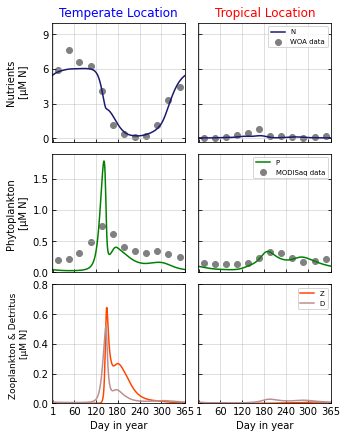

In [73]:
numcols = 2
f1, (ax1, ax2, ax3) = plt.subplots(3, numcols, sharex='col')#, sharey='row')

plt.setp((ax1, ax2, ax3), xticks=[1,60,120,180,240,300,365])
from matplotlib.ticker import MaxNLocator
for axe in (ax1, ax2, ax3):
    for i in range(numcols):
        
        axe[i].grid(True, alpha=0.5)
        axe[i].get_yaxis().set_major_locator(MaxNLocator(nbins=4))
        axe[i].tick_params(top=False, right=True, direction="in")
        
    #par1.tick_params(direction="in", axis='y', colors='b', **tkw)
        
#plt.setp((ax1, ax2, ax3, ax4), xticks=[1,60,120,180,240,300,365])
#from matplotlib.ticker import MaxNLocator
#for axe in (ax1, ax2, ax3, ax4):
#    for i in range(numcols):
#        axe[i].get_yaxis().set_major_locator(MaxNLocator(nbins=4))
#        axe[i].tick_params(top=True, right=True)

# PLOTTING


# color vectors
#colors = ['#edc951', '#dddddd', '#00a0b0', '#343436', '#cc2a36']
colors = ['#808080','#d55e00', '#cc79a7', '#0072b2', '#009e73', 'grey']
alphas = [1., 0.8, 0.6, 0.4]
lws = [2, 2.5, 4, 5.5]

def modeloutputplot(i, outarrayx, ms):
    timedays_ly = timedays[1:366]
    outarray_ly = outarrayx[1460:1825]
    
    N_Max = np.max(ms.physics.forcing.NOX.return_interpvalattime(timedays)) + np.max(ms.physics.forcing.NOX.return_interpvalattime(timedays)) * 0.1
    Pall = outarray_ly[:,1]    
    P_Max = 1.9 #np.max(ms.physics.forcing.verif.chla) + 0.9 * np.max(Pall)
    Zall = outarray_ly[:,2]
    Z_Max = 1.1#np.max(Zall) + 0.1 * np.max(Zall)
    D_Max = 0.8 #np.max(outarray_ly[:, 3]) + 0.2 * np.max(outarray_ly[:, 3])
    
    if i == 0:
        ax1[i].set_title('Temperate Location', color='blue')
    else:
        ax1[i].set_title('Tropical Location', color='red')
        

    #print(outarrayx)

    dayspermonth = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    dpm_cumsum = np.cumsum(dayspermonth) - np.array(dayspermonth)/2 #- 15
    #print(timedays_ly)


    # Figure 1
    # N
    ax1[i].scatter(dpm_cumsum, ms.physics.forcing.verif.N, label='WOA data', c='grey')
    ax1[i].plot(timedays_ly, outarray_ly[:, 0], c=culrNPZD[0], label='N')
    if i == 0:
        ax1[i].set_ylabel('Nutrients \n' '[µM N]', multialignment='center', fontsize=10)
    
    ax1[i].set_ylim(-0.3, 10)
    if i == 1:
        ax1[i].legend(fontsize='x-small')


    ChlConv = True
    # Phyto
    CtoChla = 75  # g/g
    MolarMassC = 12.0107
    CtoNratioPhyto = 6.625
    muMolartoChlaconvfactor = CtoChla / MolarMassC / CtoNratioPhyto  # Chla as mg/m-3 to

    ax2[i].scatter(dpm_cumsum, np.array(ms.physics.forcing.verif.chla) * muMolartoChlaconvfactor, label='MODISaq data', c='grey')



    ax2[i].plot(timedays_ly, Pall, c=culrNPZD[1],  label='P')
    if i == 1:
        ax2[i].legend(fontsize='x-small')
        
    if i == 0:
        ax2[i].set_ylabel('Phytoplankton \n' '[µM N]', multialignment='center', fontsize=10)
    ax2[i].set_ylim(0, P_Max)

    # Z

    ax3[i].plot(timedays_ly, Zall, c=culrNPZD[2], label='Z')
    if i == 0:
        ax3[i].set_ylabel('Zooplankton & Detritus \n' '[µM N]', multialignment='center', fontsize=9)
    ax3[i].tick_params('y', labelsize=10)
    ax3[i].set_ylim(0, Z_Max)
    #ax4[i_plot].set_title('Zooplankton')

    
    # D
    ax3[i].plot(timedays_ly, outarray_ly[:, 3], c=culrNPZD[3], label='D')
    #ax3[i].set_ylabel('Detritus \n' '[µM N]', multialignment='center', fontsize=9)
    ax3[i].set_ylim(0,D_Max)
    ax3[i].set_xlabel('Day in year')
    if i == 1:
        ax3[i].legend(fontsize='x-small')
        ax1[i].set_yticklabels([])
        ax2[i].set_yticklabels([])
        ax3[i].set_yticklabels([])
    # Legend

    
    
modeloutputplot(0, outarray, ms)
modeloutputplot(1, outarray2,ms2)
# ax1[muplot].invert_yaxis()

# Defining custom 'xlim' and 'ylim' values.
xlim = (0, 365)

# Setting the values for all axes.
plt.setp((ax1, ax2, ax3, ax4), xlim=xlim)

f1.align_ylabels()

#plt.tight_layout()

plt.subplots_adjust(hspace=0.1, wspace=0.1)

plt.savefig('Figure4.pdf', bbox_inches='tight')
plt.show()
